# Lab 4: Reconstruction from two views (knowing internal camera parameters)

In this lab you will learn how to triangulate the matching correspondences between two views of the same scene, by means of applying the Direct Linear Method (DLT). Then you will compute the camera matrices of these images given the Fundamental Matrix and the Intrinsic Matrix, and will evaluate your triangulation method on these camera matrices by estimating the reprojetion error in the triangulation. 

The last two tasks will involve the computation of depht maps by local methods (SSD, NCC), with their evaluation, and the implementation of bilateral weights on this mapping. 

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [ ]:
!pip install opencv-contrib-python==3.4.2.17
!pip install pypfm

In [1]:
import numpy as np
from numpy import linalg as LA
import cv2
import math
import sys
import random
import matplotlib
from matplotlib import pyplot as plt
from operator import itemgetter

import utils
import aux_code as aux
import team7_utils as tset
import plotly.graph_objects as go
import numpy.matlib
from math import floor
import stereo_utils as st_aux
import scipy.ndimage
import imageio
from pypfm import PFMLoader

### **1. Triangulation**

The first task is to implement the DLT method that will compute the 3D points corresponding to the matches of two images whose camera matrices are known. 

<span style='color:Green'> - Create the function triangulate(x1, x2, P1, P2, imsize) that performs a triangulation with the homogeneous algebraic method (DLT)  </span>

The entries are (x1, x2, P1, P2, imsize), where:
- x1, and x2 are two arrays of matching points in Euclidean coordinates from two different images.
- P1 and P2 are the two camera matrices of these images
- imsize is a two-dimensional vector with the image size

Test the triangulate function: use this code to validate that the function triangulate works properly


In [2]:
# Write here the method for DLT triangulation
def triangulate(x1, x2, P1, P2, imsize):

    # only one point
    if x1.ndim == 1:
        x1 = np.array([x1]).T
        x2 = np.array([x2]).T

    # number of points
    n = x1.shape[1]

    # Normalization
    x1 = x1/x1[2,:]
    x2 = x2/x2[2,:]

    nx = imsize[0];
    ny = imsize[1];

    H = [[2/nx,  0,     -1],
        [0,      2/ny,  -1],
        [0,      0,      1]]

    x1_norm = H @ x1
    x2_norm = H @ x2
    P1_norm = H @ P1
    P2_norm = H @ P2

    X = np.empty(shape=(4,n))

    for i in range(n):
        A = np.array([x1_norm[0,i]*P1_norm[2,:] - P1_norm[0,:], 
                      x1_norm[1,i]*P1_norm[2,:] - P1_norm[1,:],
                      x2_norm[0,i]*P2_norm[2,:] - P2_norm[0,:],
                      x2_norm[1,i]*P2_norm[2,:] - P2_norm[1,:]])

        # AX = 0 -> Solution: The singular vector associated to the minimum singular value of A.
        _,_,VT = LA.svd(A)
        X[:,i] = VT[-1,:]

    return X

<span style='color:Blue'> Let's test our triangulation method! </span>

In [3]:
# Two camera matrices for testing purposes
P1 = np.zeros((3,4))
P1[0,0]=P1[1,1]=P1[2,2]=1
angle = 15
theta = np.radians(angle)
c = np.cos(theta)
s = np.sin(theta)
R = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
t = np.array([[.3, .1, .2]])

P2 = np.concatenate((R, t.T), axis=1)
n = 8
rand = np.random.uniform(0,1,n)
rand = rand.reshape((1, n))
rand2 = np.random.uniform(0,1,2*n)
rand2 = rand2.reshape((2, n))
ones = np.ones((1,n))

# generate the test 3D point
X = np.concatenate((rand2, 3*rand, ones), axis=0)

x1_test = P1 @ X
x2_test = P2 @ X

# estimate the 3D point using triangulation
x_trian = triangulate(x1_test, x2_test, P1, P2, ((2,2)));

# Evaluation: compute the reprojection error
x_eucl = x_trian / x_trian[3][np.newaxis]
X_eucl = X / X[3][np.newaxis]

diff = X_eucl - x_eucl
np.set_printoptions(suppress=True)
print(f'diff:\n{diff}')

diff:
[[ 0.  0. -0. -0.  0. -0. -0.  0.]
 [ 0.  0. -0.  0.  0. -0. -0. -0.]
 [ 0.  0. -0.  0.  0. -0. -0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


### **2 Reconstruction from two views**

The goal of this section is to estimate the 3D reconstruction from two views in a practical situation where the image correspondences contain outliers. For that you will have first to compute the camera projection matrices

We will start by computing and visualizing the image matches.


<span style='color:Blue'> We implemented this method using SIFT and ORB: </span>

In [154]:
def get_matches(img1, img2, detector="sift"):
    if detector == 'orb':
        # Initiate ORB keypoint detector
        orb = cv2.ORB_create(3000)
        # find the keypoints and descriptors with ORB
        kp1, des1 = orb.detectAndCompute(img1,None)
        kp2, des2 = orb.detectAndCompute(img2,None)

        # Keypoint matching
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1,des2)
    
    elif detector == 'sift':
        # Initiate SIFT keypoint detector
        SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=6000)
        # find the keypoints and descriptors with SIFT
        kp1, des1 = SIFTdetector.detectAndCompute(img1,None)
        kp2, des2 = SIFTdetector.detectAndCompute(img2,None)

        # Keypoint matching
        bf = cv2.BFMatcher()
        matches_init = bf.knnMatch(des1,des2,k=2)

        # Apply ratio test
        matches = []
        for m,n in matches_init:
            if m.distance < 0.8*n.distance:
                matches.append(m)
    else:
        raise(NameError)

    return kp1, des1, kp2, des2, matches


<span style='color:Blue'> We'll use SIFT, as it provides a more accurate 3D reconstruction (commented in the report) </span>

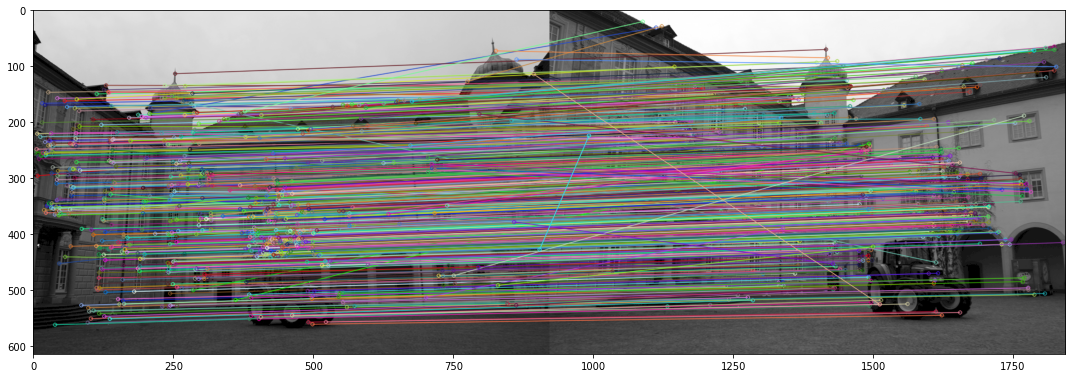

In [179]:
# Compute image correspondences #
# Read images
img1 = cv2.imread('Data/0000_s.png',cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Data/0001_s.png',cv2.IMREAD_GRAYSCALE)
h, w = img1.shape

kp1, des1, kp2, des2, matches = get_matches(img1, img2, detector='sift')

# Show "good" matches
img_12 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

<span style='color:Blue'> We have some outliers, but they will be removed with RANSAC. 

Note: We're using our own function to compute the fundamental matrix with RANSAC (from previous week) </span>

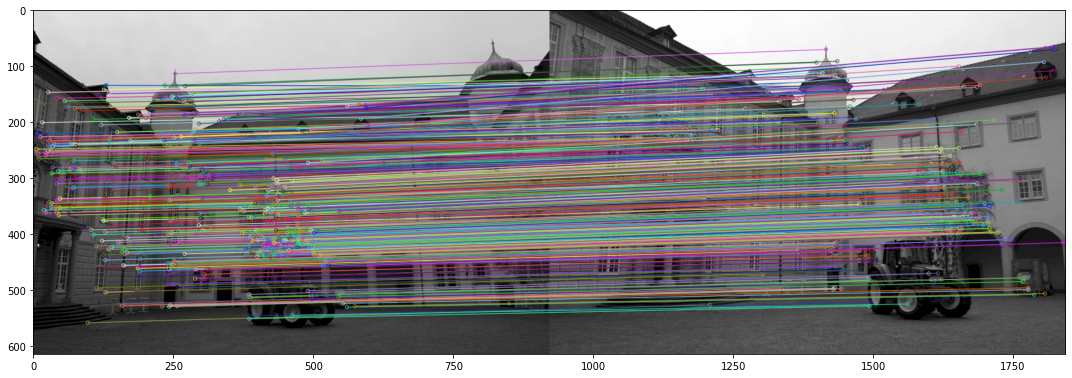

In [160]:
# Robust estimation of the fundamental matrix #
points1 = []
points2 = []
for m in matches:
    points1.append([kp1[m.queryIdx].pt[0], kp1[m.queryIdx].pt[1], 1])
    points2.append([kp2[m.trainIdx].pt[0], kp2[m.trainIdx].pt[1], 1])
    
points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

# change 'tset' for 'aux' to use the aux_code.py function
F, indices_inlier_matches = tset.Ransac_fundamental_matrix(points1, points2, 2, 5000) 
inlier_matches = itemgetter(*indices_inlier_matches)(matches)

img_12 = cv2.drawMatches(img1,kp1,img2,kp2,inlier_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

Now you should compute the candidate camera matrices.

In [162]:
# Camera calibration matrix
K = np.array([[2362.12, 0, 1520.69], [0, 2366.12, 1006.81], [0, 0, 1]])
scale = 0.3
H = np.array([[scale, 0, 0], [ 0, scale, 0], [0, 0, 1]])
K = H @ K

<span style='color:Green'> - Compute the Essential matrix from the Fundamental matrix </span>

In [163]:
def essential_from_fundamental(K, F):
    return K.T @ F @ K

E = essential_from_fundamental(K, F)

<span style='color:Blue'> We can see that E is rank 2, as the last value of D is 0: </span>

In [164]:
# check if E is rank 2 (SVD -> D[2] should be 0)
U,D,VT = LA.svd(E)
print(f'D: {D} -> Last value of D: {D[-1]:.2f}')

D: [4.54143198 4.22955763 0.        ] -> Last value of D: 0.00


<span style='color:Green'> - Estimate the camera projection matrices </span>

In [165]:
# camera projection matrix for the first camera
P1 = K @ np.eye(3,4)

# to compute the four possible matrices for the second camera, we need W:
W = np.array([[0,-1,0], 
              [1,0,0], 
              [0,0,1]])

# two possible rotations
R1 = U @ W @ VT
R2 = U @ W.T @ VT

if LA.det(R1) < 0:
    R1 = -R1

if LA.det(R2) < 0:
    R2 = -R2

# two possible translations: T and -T
T = U[:,-1]

# four camera projection matrices for the second camera
Pc2 = np.empty(shape=(4,3,4))
Pc2[0] = K @ np.column_stack((R1, T))
Pc2[1] = K @ np.column_stack((R1, -T))
Pc2[2] = K @ np.column_stack((R2, T))
Pc2[3] = K @ np.column_stack((R2, -T))

HINT: You may get improper rotations; in that case you need to change their sign.
  Let R be a rotation matrix, you may check:  
  
      if det(R) < 0  
          R = -R;  
      endif  

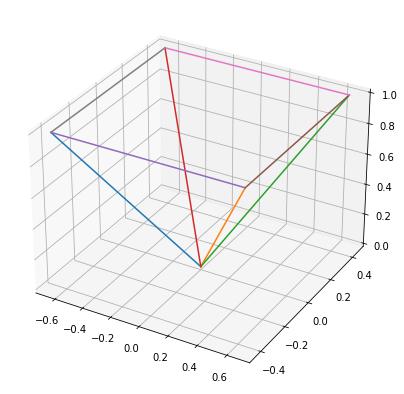

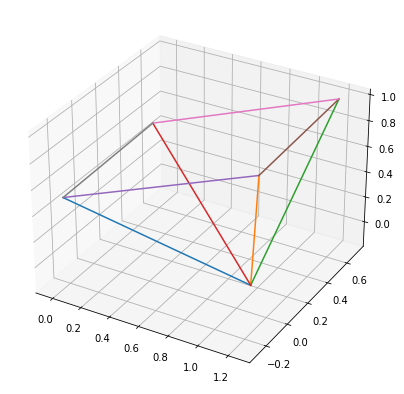

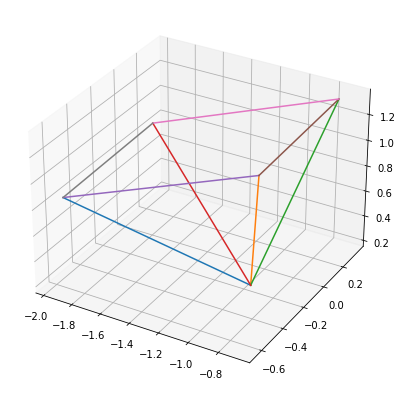

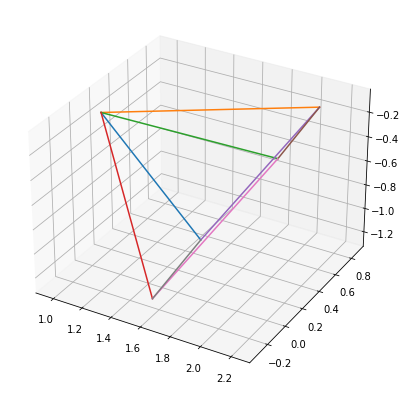

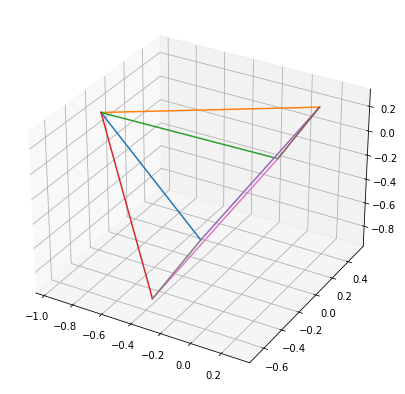

In [166]:
# plot the first camera and the four possible solutions for the second figure:
utils.plot_camera(P1,w,h, 1);
utils.plot_camera(Pc2[0],w,h, 1);
utils.plot_camera(Pc2[1],w,h, 1);
utils.plot_camera(Pc2[2],w,h, 1);
utils.plot_camera(Pc2[3],w,h, 1);

<span style='color:Green'> -Choose a second camera candidate by triangulating a match </span>

In [167]:
img1 = cv2.imread('Data/0000_s.png',cv2.IMREAD_UNCHANGED)

# inlier points
x1 = points1[:,indices_inlier_matches]
x2 = points2[:,indices_inlier_matches]

# iterate the camera matrices
for P2i in Pc2:

    # we triangulate a 3D point Xi using the camera matrix P2i
    Xi = triangulate(x1[:,0], x2[:,0], P1, P2i, [w, h])
    Xi = Xi / Xi[3][np.newaxis]
    
    # estimated x1 and x2
    x1est = P1 @ Xi
    x2est = P2i @ Xi
    
    # to select the correct P2 matrix, we must impose that the z component of x1est and x2est > 0 
    if (x1est[2] > 0) and (x2est[2] > 0):
        P2 = P2i
        break

<span style='color:Blue'> Now let's triangulate all the (inlier) points using our P2 matrix! </span>

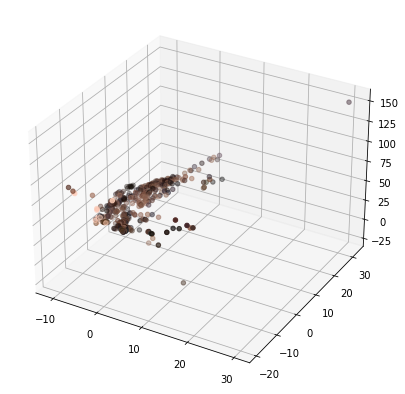

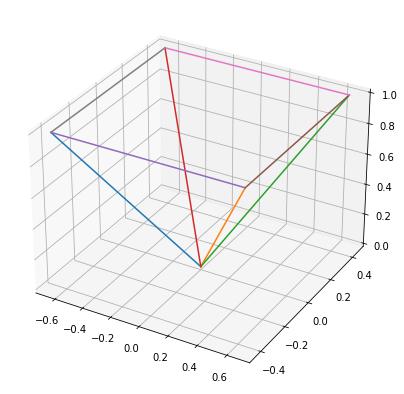

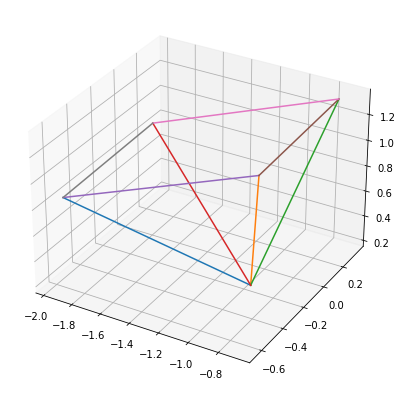

In [168]:
# Triangulate all matches.
N = x1.shape[1]
X = triangulate(x1, x2, P1, P2, [w, h])
X = X / X[3][np.newaxis]

# Render the 3D point cloud
x_img = np.transpose(x1[:2]).astype(int)
rgb_txt = (img1[x_img[:,1], x_img[:,0]])/255
utils.plot_points(np.transpose(X[:3]), rgb_txt)
utils.plot_camera(P1,w,h,1);
utils.plot_camera(P2,w,h,1);


<span style='color:Blue'> Now, let's plot it in 3D (with the corresponding cameras!!). If the 3D plot is not visible here, check the report to see some 
wonderful captures </span>

In [260]:
def optical_center(P):
    U, d, Vt = np.linalg.svd(P)
    o = Vt[-1, :3] / Vt[-1, -1]
    return o

def view_direction(P, x):
    # Vector pointing to the viewing direction of a pixel
    # We solve x = P v with v(3) = 0
    v = np.linalg.inv(P[:,:3]) @ np.array([x[0], x[1], 1])
    return v

def plot_camera(P, w, h, fig, legend):
    
    o = optical_center(P)
    scale = 2
    p1 = o + view_direction(P, [0, 0]) * scale
    p2 = o + view_direction(P, [w, 0]) * scale
    p3 = o + view_direction(P, [w, h]) * scale
    p4 = o + view_direction(P, [0, h]) * scale
    
    x = np.array([p1[0], p2[0], o[0], p3[0], p2[0], p3[0], p4[0], p1[0], o[0], p4[0], o[0], (p1[0]+p2[0])/2])
    y = np.array([p1[1], p2[1], o[1], p3[1], p2[1], p3[1], p4[1], p1[1], o[1], p4[1], o[1], (p1[1]+p2[1])/2])
    z = np.array([p1[2], p2[2], o[2], p3[2], p2[2], p3[2], p4[2], p1[2], o[2], p4[2], o[2], (p1[2]+p2[2])/2])
    
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='lines',name=legend))
    
    return

ny, nx = img1.shape

fig = go.Figure()

plot_camera(P1, nx, ny, fig, "camera{0}".format(1))
plot_camera(P2, nx, ny, fig, "camera{0}".format(2))
tset.plot_points(np.transpose(X[:3]), rgb_txt,fig)
fig.show()

<span style='color:Green'> Compute the reprojection errors:  
    -plot the histogram of reprojection errors, and  
    -print the mean reprojection error </span>

Mean reprojection error: 60.90398588884696


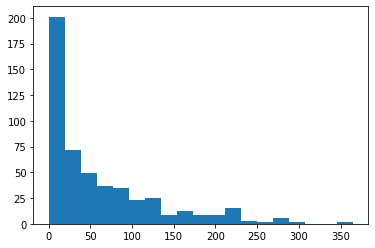

In [190]:
def reprojection_errors(x1,x2,P1,P2,X):

    # homogeneous to cartesians
    x1 = x1[:2,:]/x1[2,:]
    x2 = x2[:2,:]/x2[2,:]

    x1est = P1 @ X
    x1est = x1est[:2,:]/x1est[2,:]

    x2est = P2 @ X
    x2est = x2est[:2,:]/x2est[2,:]

    err1 = np.sum((x1-x1est)**2,axis=0)
    err2 = np.sum((x2-x2est)**2, axis=0)

    return err1+err2

err = reprojection_errors(x1,x2,P1,P2,X)
plt.hist(err,bins='auto')
err_mean = np.mean(err)
print(f'Mean reprojection error: {err_mean}')

### **3. Depth map computation with local methods (SSD)**

Data images: 'scene1.row3.col3.ppm','scene1.row3.col4.ppm'  
Disparity ground truth: 'truedisp.row3.col3.pgm'

<span style='color:Green'> - Write a function called 'stereo_computation' that computes the disparity between a pair of rectified images using a local method based on a matching cost between two local windows.  </span>

The input parameters are 5:
- left image
- right image
- minimum disparity
- maximum disparity
- window size (e.g. a value of 3 indicates a 3x3 window)
- matching cost (the user may able to choose between SSD and NCC costs)

In this part we ask to implement only the SSD cost


<span style='color:Green'> - Evaluate the results changing the window size (e.g. 3x3, 9x9, 21x21,31x31) and the Mean Square Error (MSE). Comment the results.  </span>

 **Note 1**: Use grayscale images  
 
 **Note 2**: For this first set of images use 0 as minimum disparity and 16 as the the maximum one.

In [181]:
# Mean Square Error to compare the estimated disparity map and the groundtruth
def mse(actual, pred): 
    return (np.square(actual - pred)).mean() 


def stereo_computation(left_img, right_img, min_disparity, max_disparity, win_size, bilateral_weights=False, method='ssd'): # Other methods: ncc
    """
    -left image
    -right image
    -minimum disparity
    -maximum disparity
    -window size
    -bilateral_weights
    -matching cost
    """
    height, width = left_img.shape
    disparity = np.zeros(shape=(height, width))
    win_step = floor(win_size/2)        

    # Iterate over the image
    for i in range(win_step, height-win_step):
        for j in range(win_step, width-win_step):
            
            # Get window on first image for this iteration
            left_window = left_img[i-win_step:i+win_step+1, j-win_step:j+win_step+1]

            # Values used to slide the window on the right image
            min_d = max(win_step, j+min_disparity)
            max_d = min(width-1-win_step, j+max_disparity)

            window_height, window_width = left_window.shape

            # Weigts are 1 for each pixel. 
            # If we are using bilateral weights, then the weights
            # are updated according to the formula
            weights = np.ones(shape=(window_height, window_width))/left_window.size

            if bilateral_weights:
                c = abs(left_window[win_step,win_step]-left_window)
                g = np.sqrt((i - np.matlib.repmat(np.arange(i-win_step,i+win_step+1), win_size,1).T)**2 \
                           +(j - np.matlib.repmat(np.arange(j-win_step,j+win_step+1), win_size,1))**2)
   
                # The gamma values have been selected according to the original paper
                # https://hal-enpc.archives-ouvertes.fr/hal-01131412/file/article.pdf
                gamma_col = 12
                gamma_pos = 17
                weights = np.dot(np.exp(-c/gamma_col), np.exp(-g/gamma_pos))              

            if method=='ssd':
                error = np.inf
                for k in range(min_d, max_d):
                    # Get window on the right image
                    right_window = right_img[i-win_step:i+win_step+1, 
                                             k-win_step:k+win_step+1]

                    # Our cost is the sum of squared differences between the 2 windows
                    C = np.sum(np.dot(weights,abs(left_window-right_window)**2))
                    if C < error:
                        error = C
                        best_d = k

            elif method=='ncc':
                correlation = -np.inf   

                for k in range(min_d, max_d):
                    # Get window on the right image
                    right_window = right_img[i-win_step:i+win_step+1, 
                                             k-win_step:k+win_step+1]

                    mean_left_window = (weights*left_window)
                    mean_right_window = (weights*right_window)
                    std_left_window = np.sqrt(np.sum((weights*left_window)**2))
                    std_right_window = np.sqrt(np.sum((weights*right_window)**2))
                    
                    C = np.sum(weights*(left_window-mean_left_window)*(right_window-mean_right_window))/(std_left_window*std_right_window + sys.float_info.epsilon)
                    
                    # In this case, the higher the correlation the better 
                    if C > correlation:
                        correlation = C
                        best_d = k    
            else:
                raise(NameError)
            
            disparity[i, j] = best_d -j

    return disparity


In [182]:
img_stereo_1 = cv2.imread('./Data/scene1.row3.col3.ppm', cv2.IMREAD_GRAYSCALE)
img_stereo_2 = cv2.imread('./Data/scene1.row3.col4.ppm', cv2.IMREAD_GRAYSCALE)

min_disparity = 0
max_disparity = 16
w_sizes = [3, 9, 21, 31]
ssd_no_bilateral_disparities = np.zeros(shape=(len(w_sizes), img_stereo_1.shape[0], img_stereo_1.shape[1]))

for idx,size in enumerate(w_sizes):
    ssd_no_bilateral_disparities[idx,:,:] = stereo_computation(img_stereo_2, 
                                                                img_stereo_1, 
                                                                min_disparity, 
                                                                max_disparity, 
                                                                size, 
                                                                bilateral_weights=False, 
                                                                method='ssd')

<span style='color:Blue'> We first plot the groundtruth:</span>

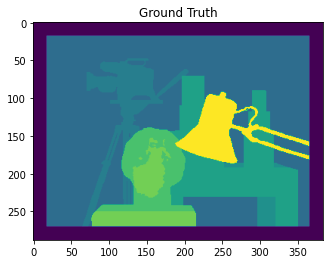

In [188]:
img_gt = cv2.imread('./Data/truedisp.row3.col3.pgm', cv2.IMREAD_GRAYSCALE)
plt.imshow(img_gt)
_ = plt.title("Ground Truth")

<span style='color:Blue'> Now let's plot the different disparities and compare them against the groundtruth </span>

Error between GT and Window size 3 is 14.908248336226851
Error between GT and Window size 9 is 9.548131872106481
Error between GT and Window size 21 is 6.121437355324074
Error between GT and Window size 31 is 4.01050708912037


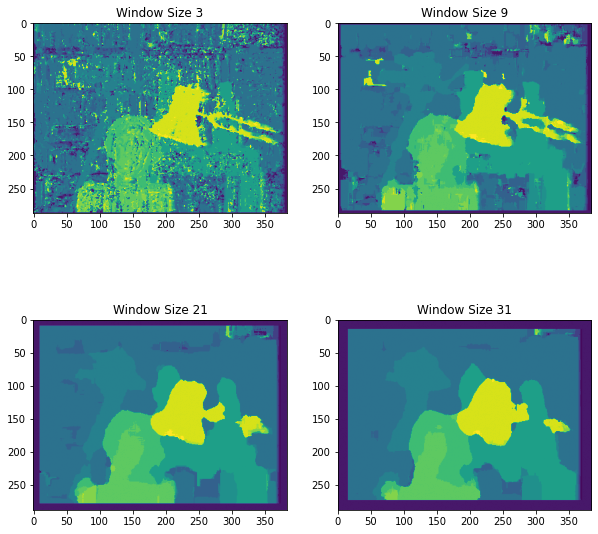

In [187]:
# draw graph 
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10.0, 10.0)
axes[0][0].imshow(ssd_no_bilateral_disparities[0])
axes[0][0].set_title("Window Size 3")
axes[0][1].imshow(ssd_no_bilateral_disparities[1])
axes[0][1].set_title("Window Size 9")
axes[1][0].imshow(ssd_no_bilateral_disparities[2])
axes[1][0].set_title("Window Size 21")
axes[1][1].imshow(ssd_no_bilateral_disparities[3])
axes[1][1].set_title("Window Size 31")

for idx, size in enumerate(w_sizes):
    print("Error between GT and Window size {} is {}"\
            .format(size, mse(img_gt/max_disparity, ssd_no_bilateral_disparities[idx])))

<span style='color:Blue'> We can also compute the depth map knowing *a priori* the focal length and baseline of the camera configuration (source: https://vision.middlebury.edu/stereo/data/scenes2014/) </span>

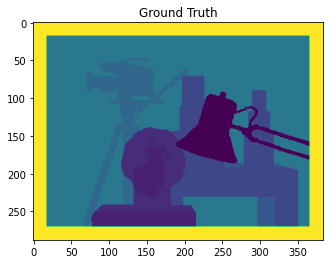

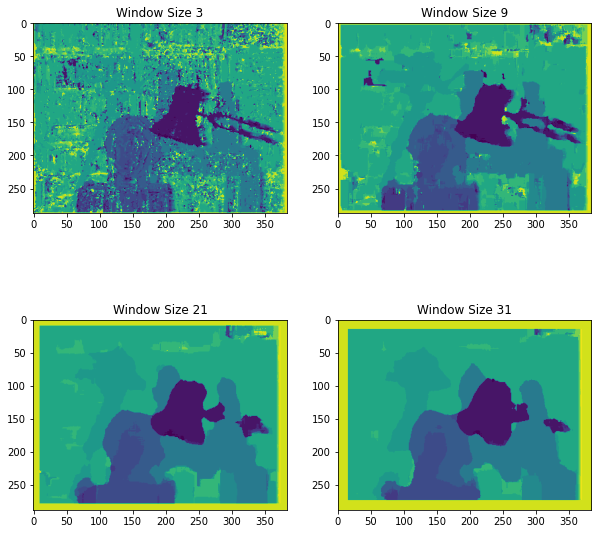

In [189]:
# Now, knowing the baseline and the focal length, we can compute the depth maps
baseline=193.001
f = 3997.684

plt.imshow((baseline*f)/(img_gt + 131.111))
_ = plt.title("Ground Truth")

ssd_no_bilateral_depth = np.zeros(shape=(ssd_no_bilateral_disparities.shape))

for idx,disparity in enumerate(ssd_no_bilateral_disparities):
    ssd_no_bilateral_depth[idx] = (baseline*f)/(disparity + 131.111)

# draw graph 
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10.0, 10.0)
axes[0][0].imshow(ssd_no_bilateral_depth[0])
axes[0][0].set_title("Window Size 3")
axes[0][1].imshow(ssd_no_bilateral_depth[1])
axes[0][1].set_title("Window Size 9")
axes[1][0].imshow(ssd_no_bilateral_depth[2])
axes[1][0].set_title("Window Size 21")
axes[1][1].imshow(ssd_no_bilateral_depth[3])
axes[1][1].set_title("Window Size 31")

<span style='color:Blue'> We also used the function *StereoBM_create* from openCV to check if our implementation provides acceptable results </span>

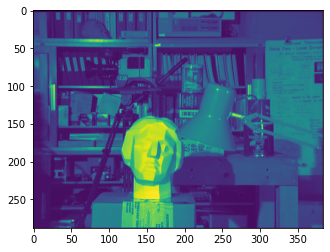

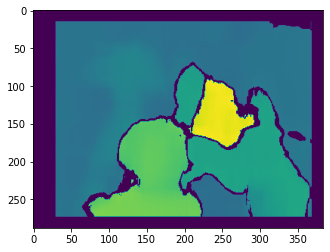

MSE between openCV's solution and ours: 8.642894744873047


In [196]:
imgL = cv2.imread('./Data/scene1.row3.col3.ppm',0)
imgR = cv2.imread('./Data/scene1.row3.col4.ppm',0)

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=31)
disparity = stereo.compute(imgL,imgR)

plt.imshow(imgL)
plt.show()
plt.imshow(disparity)
plt.show()

print("MSE between openCV's solution and ours: {}".format(mse(disparity/max_disparity, ssd_no_bilateral_disparities[3])))

<span style='color:Blue'> As observed, the result is similar to ours, so good news :) </span>

### **4. Depth map computation with local methods (NCC)**

<span style='color:Green'> - Complete the previous function by adding the implementation of the NCC cost. </span>

<span style='color:Green'>  Evaluate the results changing the window size (e.g. 3x3, 9x9, 21x21,31x31). Comment the results. </span>

<span style='color:Blue'> The NCC method is implemented on function *stereo_computation*, presented above. </span>

In [195]:
img_stereo_1 = cv2.imread('./Data/scene1.row3.col3.ppm', cv2.IMREAD_GRAYSCALE)
img_stereo_2 = cv2.imread('./Data/scene1.row3.col4.ppm', cv2.IMREAD_GRAYSCALE)

min_disparity = 0
max_disparity = 16
w_sizes = [3, 9, 21, 31]
ncc_no_bilateral_disparities = np.zeros(shape=(len(w_sizes), img_stereo_1.shape[0], img_stereo_1.shape[1]))

for idx,size in enumerate(w_sizes):
    ncc_no_bilateral_disparities[idx,:,:] = stereo_computation(img_stereo_2, 
                                                            img_stereo_1, 
                                                            min_disparity, 
                                                            max_disparity, 
                                                            size, 
                                                            bilateral_weights=False, 
                                                            method='ncc')

<span style='color:Blue'> Now we plot the different disparities and compare them against the ground truth </span>

Error between GT and Window size 3 is 17.77218062789352
Error between GT and Window size 9 is 10.22312644675926
Error between GT and Window size 21 is 6.482819733796297
Error between GT and Window size 31 is 4.484284577546297


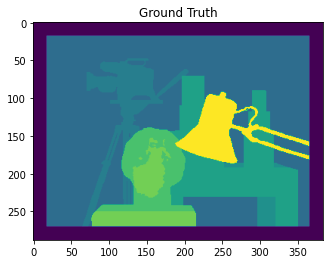

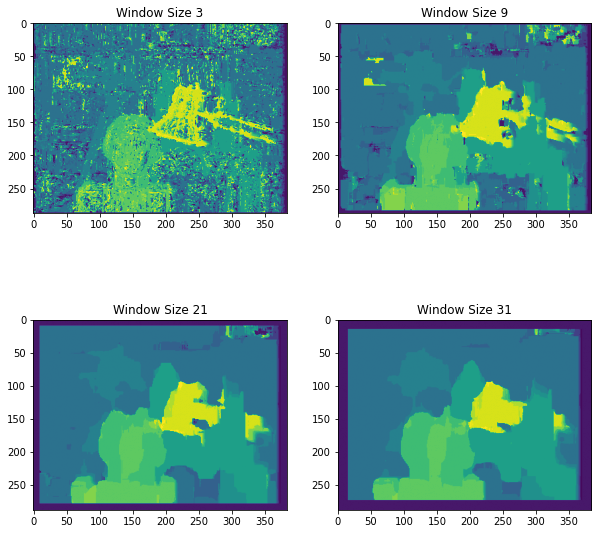

In [198]:
img_gt = cv2.imread('./Data/truedisp.row3.col3.pgm', cv2.IMREAD_GRAYSCALE)
plt.imshow(img_gt)
plt.title("Ground Truth")
  
# draw graph 
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10.0, 10.0)
axes[0][0].imshow(ncc_no_bilateral_disparities[0])
axes[0][0].set_title("Window Size 3")
axes[0][1].imshow(ncc_no_bilateral_disparities[1])
axes[0][1].set_title("Window Size 9")
axes[1][0].imshow(ncc_no_bilateral_disparities[2])
axes[1][0].set_title("Window Size 21")
axes[1][1].imshow(ncc_no_bilateral_disparities[3])
axes[1][1].set_title("Window Size 31")

for idx, size in enumerate(w_sizes):
    print("Error between GT and Window size {} is {}"\
            .format(size, mse(img_gt/max_disparity, ncc_no_bilateral_disparities[idx])))

<span style='color:Blue'> Again, knowing *a priori* the baseline and focal length, we can compute the depth </span>

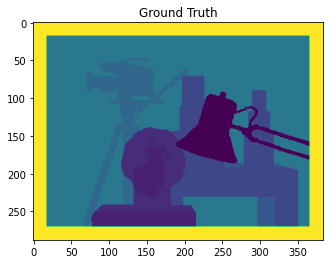

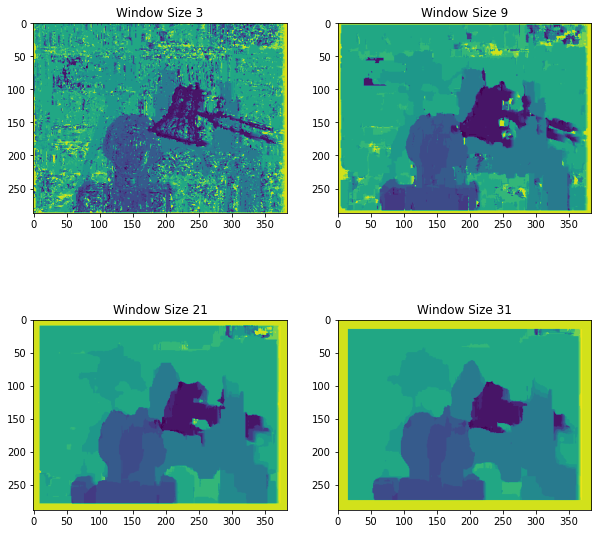

In [199]:
baseline=193.001
f = 3997.684

plt.imshow((baseline*f)/(img_gt + 131.111))
plt.title("Ground Truth")

ncc_no_bilateral_depth = np.zeros(shape=(ncc_no_bilateral_disparities.shape))

for idx,disparity in enumerate(ncc_no_bilateral_disparities):
    ncc_no_bilateral_depth[idx] = (baseline*f)/(disparity + 131.111)

# draw graph 
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10.0, 10.0)
axes[0][0].imshow(ncc_no_bilateral_depth[0])
axes[0][0].set_title("Window Size 3")
axes[0][1].imshow(ncc_no_bilateral_depth[1])
axes[0][1].set_title("Window Size 9")
axes[1][0].imshow(ncc_no_bilateral_depth[2])
axes[1][0].set_title("Window Size 21")
axes[1][1].imshow(ncc_no_bilateral_depth[3])
axes[1][1].set_title("Window Size 31")

### **5. Depth map computation with local methods**

Data images: '0001_rectified_s.png','0002_rectified_s.png'

<span style='color:Green'> - Test the functions implemented in the previous section with the facade images. Try different matching costs and window sizes and comment the results. </span>
    
Notice that in this new data the minimum and maximum disparities may change.


<span style='color:Blue'> The minimum disparity is set to 0 because we sorted the images from left to right, so the disparity will be always greater or equal 
than 0. On the other hand, we try different costs (ssd and ncc), window sizes (3, 9, 21 and 31) and different max disparities (32, 48).

Note: we've tried even more values, but we don't want the notebook to be huge </span>

In [206]:
# Load images
img_stereo_castle_1 = cv2.imread("./Data/0001_rectified_s.png", cv2.IMREAD_GRAYSCALE)
img_stereo_castle_2 = cv2.imread("./Data/0002_rectified_s.png", cv2.IMREAD_GRAYSCALE)

# SSD
min_disparity = [0]
max_disparity = [32,48]
costs = ['ssd', 'ncc']
window_size = [3,9,21,31]

disparity_test = np.zeros(shape=(len(costs)*len(min_disparity)*len(max_disparity)*len(window_size), 
                                 img_stereo_castle_1.shape[0],
                                 img_stereo_castle_1.shape[1]))
idx = 0
for cost in costs:
    for min_dis in min_disparity:
        for max_dis in max_disparity:
            for size in window_size:
                disparity_test[idx] = stereo_computation(img_stereo_castle_1, 
                                                        img_stereo_castle_2, 
                                                        min_dis, 
                                                        max_dis, 
                                                        size, 
                                                        bilateral_weights=False, 
                                                        method=cost)
                idx += 1

<span style='color:Blue'> Let's plot the results for each combination, first: SSD with maximum disparity of 32 </span> 

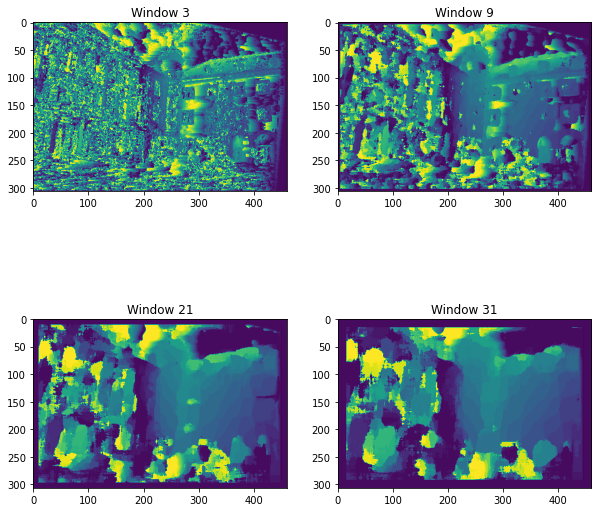

In [207]:
# ssd, max disparity 32
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10.0, 10.0)
axes[0][0].imshow(disparity_test[0])
axes[0][0].set_title("Window {}".format(3))
axes[0][1].imshow(disparity_test[1])
axes[0][1].set_title("Window {}".format(9))
axes[1][0].imshow(disparity_test[2])
axes[1][0].set_title("Window {}".format(21))
axes[1][1].imshow(disparity_test[3])
axes[1][1].set_title("Window {}".format(31))

<span style='color:Blue'> SSD with maximum disparity of 48 </span> 

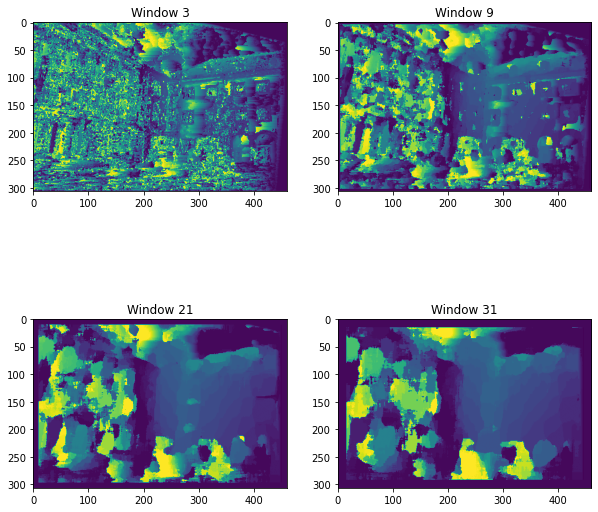

In [208]:
# ssd, max disparity 48
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10.0, 10.0)
axes[0][0].imshow(disparity_test[4])
axes[0][0].set_title("Window {}".format(3))
axes[0][1].imshow(disparity_test[5])
axes[0][1].set_title("Window {}".format(9))
axes[1][0].imshow(disparity_test[6])
axes[1][0].set_title("Window {}".format(21))
axes[1][1].imshow(disparity_test[7])
axes[1][1].set_title("Window {}".format(31))

<span style='color:Blue'> NCC with maximum disparity of 32 </span> 

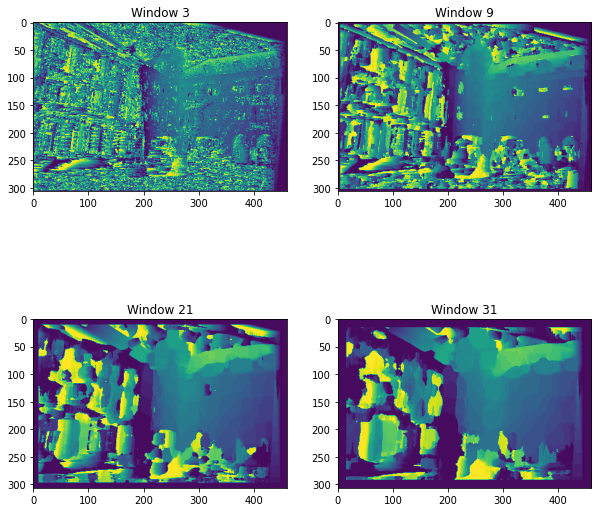

In [211]:
# ncc, max disparity 32
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10.0, 10.0)
axes[0][0].imshow(disparity_test[8])
axes[0][0].set_title("Window {}".format(3))
axes[0][1].imshow(disparity_test[9])
axes[0][1].set_title("Window {}".format(9))
axes[1][0].imshow(disparity_test[10])
axes[1][0].set_title("Window {}".format(21))
axes[1][1].imshow(disparity_test[11])
axes[1][1].set_title("Window {}".format(31))

<span style='color:Blue'> NCC with maximum disparity of 48 </span> 

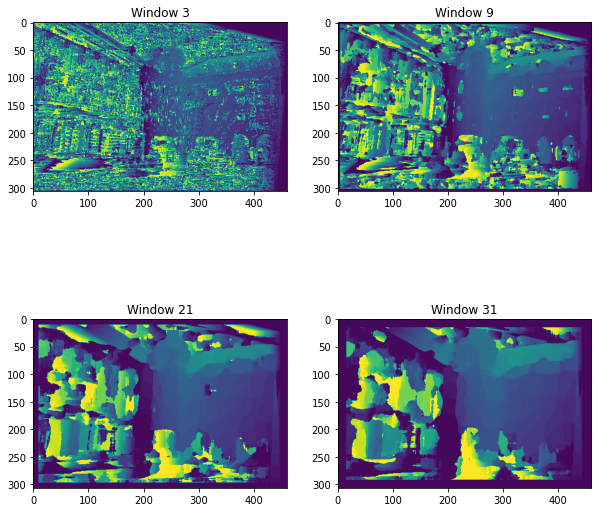

In [212]:
# ncc, max disparity 48
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10.0, 10.0)
axes[0][0].imshow(disparity_test[12])
axes[0][0].set_title("Window {}".format(3))
axes[0][1].imshow(disparity_test[13])
axes[0][1].set_title("Window {}".format(9))
axes[1][0].imshow(disparity_test[14])
axes[1][0].set_title("Window {}".format(21))
axes[1][1].imshow(disparity_test[15])
axes[1][1].set_title("Window {}".format(31))

### **6. Bilateral weights**

<span style='color:Green'> - Modify the 'stereo_computation' so that you can use bilateral weights (or adaptive support weights) in the matching cost of two windows. </span>
    
Reference paper: Yoon and Kweon, "Adaptive Support-Weight Approach for Correspondence Search", IEEE PAMI 2006

<span style='color:Green'> -  Comment the results and compare them to the previous results (no weights).</span>

**Note**: Use grayscale images (the paper uses color images)

<span style='color:Blue'> The bilateral weights algorithm is implemented on function *stereo_computation*, presented above. Let's start with SSD</span>

In [216]:
# BILATERAL WITH SSD
img_stereo_1 = cv2.imread('./Data/scene1.row3.col3.ppm', cv2.IMREAD_GRAYSCALE)
img_stereo_2 = cv2.imread('./Data/scene1.row3.col4.ppm', cv2.IMREAD_GRAYSCALE)

min_disparity = 0
max_disparity = 16
w_sizes = [3, 9, 21, 31]
ssd_bilateral_disparities = np.zeros(shape=(len(w_sizes), img_stereo_1.shape[0], img_stereo_1.shape[1]))

for idx,size in enumerate(w_sizes):
    ssd_bilateral_disparities[idx,:,:] = stereo_computation(img_stereo_2, 
                                                            img_stereo_1, 
                                                            min_disparity, 
                                                            max_disparity, 
                                                            size, 
                                                            bilateral_weights=True, 
                                                            method='ssd')

<span style='color:Blue'> Now let's plot the different disparities and compare them against the ground truth. </span>

Error between GT and Window size 3 is 15.09548611111111
Error between GT and Window size 9 is 9.554099754050926
Error between GT and Window size 21 is 6.0812807436342595
Error between GT and Window size 31 is 3.8813838252314814


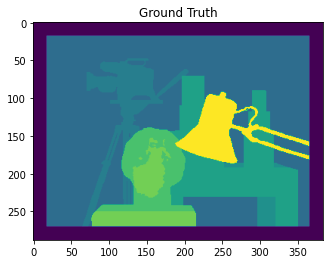

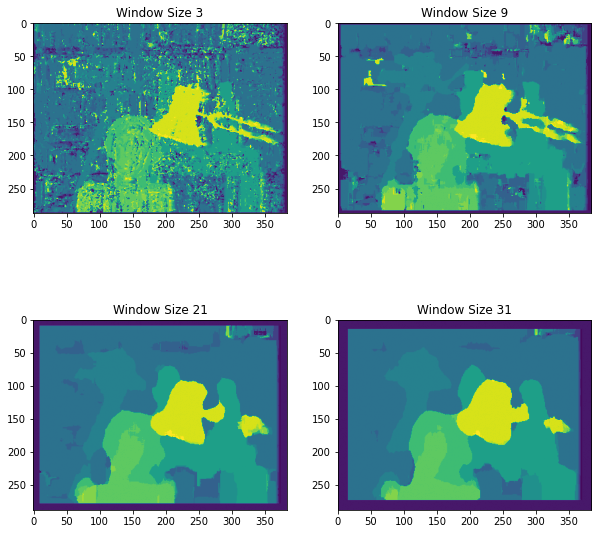

In [217]:
img_gt = cv2.imread('./Data/truedisp.row3.col3.pgm', cv2.IMREAD_GRAYSCALE)
plt.imshow(img_gt)
plt.title("Ground Truth")

fig, axes = plt.subplots(2,2)
fig.set_size_inches(10.0, 10.0)
axes[0][0].imshow(ssd_bilateral_disparities[0])
axes[0][0].set_title("Window Size 3")
axes[0][1].imshow(ssd_bilateral_disparities[1])
axes[0][1].set_title("Window Size 9")
axes[1][0].imshow(ssd_bilateral_disparities[2])
axes[1][0].set_title("Window Size 21")
axes[1][1].imshow(ssd_bilateral_disparities[3])
axes[1][1].set_title("Window Size 31")

for idx, size in enumerate(w_sizes):
    print("Error between GT and Window size {} is {}".format(size, mse(img_gt/max_disparity, ssd_bilateral_disparities[idx])))

<span style='color:Blue'> Again, knowing *a priori* the baseline and focal length, we could compute the depth (we won't plot it because the notebook will
be huge) </span>

<span style='color:Blue'> Now, let's compute the disparity map using NCC and bilateral weights </span>

In [218]:
img_stereo_1 = cv2.imread('./Data/scene1.row3.col3.ppm', cv2.IMREAD_GRAYSCALE)
img_stereo_2 = cv2.imread('./Data/scene1.row3.col4.ppm', cv2.IMREAD_GRAYSCALE)

min_disparity = 0
max_disparity = 16
w_sizes = [3, 9, 21, 31]
ncc_bilateral_disparities = np.zeros(shape=(len(w_sizes), img_stereo_1.shape[0], img_stereo_1.shape[1]))

for idx,size in enumerate(w_sizes):
    ncc_bilateral_disparities[idx,:,:] = stereo_computation(img_stereo_2, 
                                                            img_stereo_1, 
                                                            min_disparity, 
                                                            max_disparity, 
                                                            size, 
                                                            bilateral_weights=True, 
                                                            method='ncc')

<span style='color:Blue'> Now let's plot the different disparities and compare them against the ground truth </span>

Error between GT and Window size 3 is 29.395842375578702
Error between GT and Window size 9 is 22.47606517650463
Error between GT and Window size 21 is 14.46461769386574
Error between GT and Window size 31 is 10.812454788773149


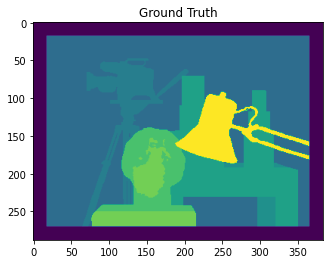

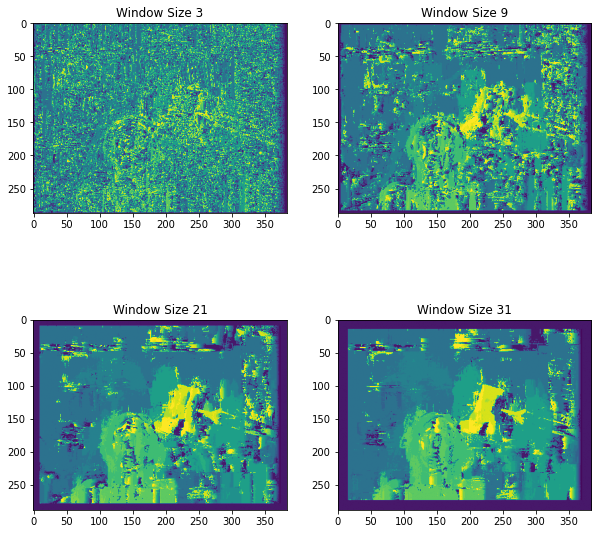

In [219]:
img_gt = cv2.imread('./Data/truedisp.row3.col3.pgm', cv2.IMREAD_GRAYSCALE)
plt.imshow(img_gt)
plt.title("Ground Truth")
  
# draw graph 
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10.0, 10.0)
axes[0][0].imshow(ncc_bilateral_disparities[0])
axes[0][0].set_title("Window Size 3")
axes[0][1].imshow(ncc_bilateral_disparities[1])
axes[0][1].set_title("Window Size 9")
axes[1][0].imshow(ncc_bilateral_disparities[2])
axes[1][0].set_title("Window Size 21")
axes[1][1].imshow(ncc_bilateral_disparities[3])
axes[1][1].set_title("Window Size 31")

for idx, size in enumerate(w_sizes):
    print("Error between GT and Window size {} is {}".format(size, mse(img_gt/max_disparity, ncc_bilateral_disparities[idx])))

### OPTIONAL:  Stereo computation with Belief Propagation

Use the UGM library used in module 2 and implement a stereo computation method that minimizes a simple stereo energy with belief propagation. For example, use an L2 or L1 pixel-based data term (SSD or SAD) and the same regularization term you used in module 2. Or pick a stereo paper (based on belief propagation) from the literature and implement it. Pick a simple method or just simplify the method they propose.




<span style='color:Blue'> Note that the aforementioned UGM library used in module 2 is a Matlab library. Luckily, we were able to find a [Python Library](https://github.com/alexprz/StereoMatching). 
We went over the different functions and certified that it indeed follows the methodology explained in [Stereo Matching Using Belief Propagation (Jian Sun et al.)](http://www.jiansun.org/papers/Stereo_PAMI.pdf).
More theoretical details on the report. </span>

<span style='color:Blue'> Let's start with the the scene1 images </span>

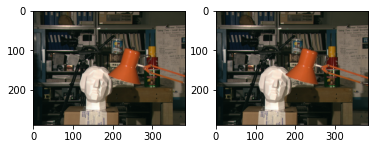

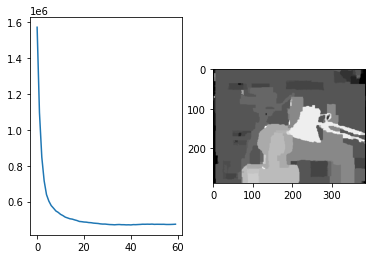

In [224]:
# Parameters
num_disp_values=16 # these images have disparity between 0 and 15.
Lambda=10.0
nb_iterations=60

# Input
img_left = cv2.imread('./Data/scene1.row3.col3.ppm')
img_right = cv2.imread('./Data/scene1.row3.col4.ppm')

plt.subplot(121)
plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
plt.show()

# Convert as float gray images
img_left=img_left.astype(float)
img_right=img_right.astype(float)

# Gaussian filtering
I1=scipy.ndimage.filters.gaussian_filter(img_left, 0.6)
I2=scipy.ndimage.filters.gaussian_filter(img_right, 0.6)

disparity,energy = st_aux.stereo_bp(I1,I2,num_disp_values,Lambda, num_iterations=nb_iterations)
cv2.imwrite('disparity_{:g}.png'.format(Lambda),disparity)

# Plot results
plt.subplot(121)
plt.plot(energy)
plt.subplot(122)
plt.imshow(disparity,cmap='gray',vmin=0,vmax=num_disp_values-1)
plt.show()

<span style='color:Blue'> Now let's try with the facade images </span>

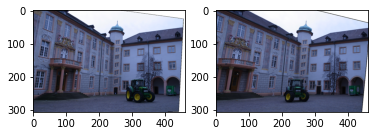

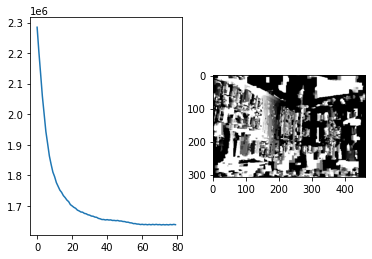

In [226]:
# Parameters
num_disp_values=16 # these images have disparity between 0 and 15.
Lambda=5.0 
nb_iterations=80 

# For facades images
img_left = cv2.imread('./Data/0001_rectified_s.png')
img_right = cv2.imread('./Data/0002_rectified_s.png')

plt.subplot(121)
plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB))
plt.show()

# Convert as float gray images
img_left=img_left.astype(float)
img_right=img_right.astype(float)

# Gaussian filtering
I1=scipy.ndimage.filters.gaussian_filter(img_left, 0.6)
I2=scipy.ndimage.filters.gaussian_filter(img_right, 0.6)

disparity,energy = st_aux.stereo_bp(I1,I2,num_disp_values,Lambda, num_iterations=nb_iterations)
cv2.imwrite('disparity_{:g}.png'.format(Lambda),disparity)

# Plot results
plt.subplot(121)
plt.plot(energy)
plt.subplot(122)
plt.imshow(disparity,cmap='gray',vmin=0,vmax=num_disp_values-1)
plt.show()



### OPTIONAL:  New view synthesis

In this task you are asked to implement part of the new view synthesis method presented in the following paper: S. Seitz, and C. Dyer, View morphing, Proc. ACM SIGGRAPH 1996.

You will use a pair of rectified stereo images (no need for prewarping and postwarping stages) and their corresponding ground truth disparities (folder "new_view"). Remember to take into account occlusions as explained in the lab session. Once done you can apply the code to the another pair of rectified images provided in the material and use the estimated disparities with previous methods.


<span style='color:Blue'> Original left and right images </span>

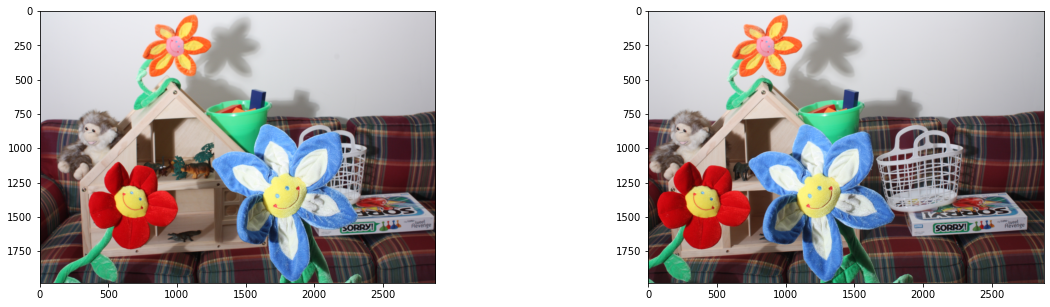

In [227]:
Il = cv2.imread('./Data/new_view/im0.png',cv2.IMREAD_COLOR)
Ir = cv2.imread('./Data/new_view/im1.png', cv2.IMREAD_COLOR)

fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].imshow(cv2.cvtColor(Il, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(Ir, cv2.COLOR_BGR2RGB))

<span style='color:Blue'> Corresponding left and right disparity maps </span>

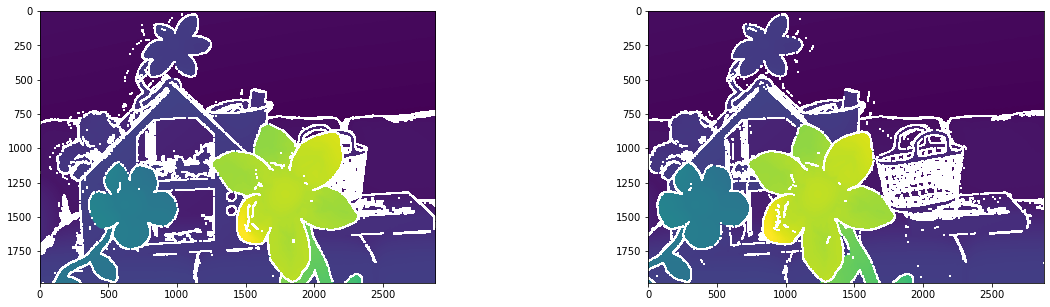

In [229]:
loader = PFMLoader(color=False, compress=False)

dl = np.flipud(loader.load_pfm('./Data/new_view/disp0.pfm'))
dr = np.flipud(loader.load_pfm('./Data/new_view/disp1.pfm'))

fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].imshow(dl)
ax[1].imshow(dr)
plt.savefig('./results/disparity_maps.png')

<span style='color:Blue'> We'll rescale the images to reduce the computational cost </span>

In [230]:
def resize_img(img, scale_factor):
    #calculate the 50 percent of original dimensions
    width = int(img.shape[1] * scale_factor)
    height = int(img.shape[0] * scale_factor)

    # dsize
    dsize = (width, height)

    # resize image
    return cv2.resize(img, dsize)

# let's speed up the computation by rescaling the images
scale_factor = 0.25
Il = resize_img(Il, scale_factor)
Ir = resize_img(Ir, scale_factor)

# we also have to rescale the disparity (values of the disparity maps dl and dr)
dl = resize_img(dl, scale_factor)*scale_factor
dr = resize_img(dr, scale_factor)*scale_factor

<span style='color:Blue'> Let's create 9 new views with s = \[0.1, 0.2, ..., 0.9], and also use the original views (s = 0 -> left and s = 1 -> right) to create
a GIF! </span>

In [231]:
h,w,_ = Il.shape

new_views = []

# factor to check if there's an occlusion
occlusion_factor = 1
new_view_img = np.empty(shape=Il.shape)

# s = [0, 0.1, 0.2, 0.3, ..., 1.0]
for s in np.linspace(0, 1, 11):
    s = round(s, 2)
    for y in range(h):
        for x in range(w):

            # the point has to be inside the image.size range
            k = min(max(x+dr[y,x], 0), w-1)
            p = round((s*x + (1-s)*k))
            k = int(k)

            # if there are no occlusions
            if abs(dr[y,x] - dl[y,k]) <= occlusion_factor:
                new_view_img[y,p,:] = (1-s)*Il[y,k,:] + s*Ir[y,x,:]

            # if there's an occlusion, just copy the pixel from the right image
            else:
                if dr[y,x] >= 0 and dr[y,x] < math.inf:
                    new_view_img[y,p,:] = Ir[y,x,:]

    for y in range(h):
        for x in range(w):

            # the point has to be inside the image.size range
            k = min(max(x-dl[y,x] ,0), w-1)
            p = round((1-s)*x + s*k)
            k = int(k)

            # if there are no occlusions
            if abs(dl[y,x]-dr[y,k]) <= occlusion_factor:
                new_view_img[y,p,:] = (1-s)*Il[y,x,:] + s*Ir[y,k,:]

            # if there's an occlusion, just copy the pixel from the left image
            else:
                if dl[y,x] >= 0 and dl[y,x] < math.inf:
                    new_view_img[y,p,:] = Il[y,x,:]

    new_views.append(cv2.cvtColor(new_view_img.astype('uint8'), cv2.COLOR_BGR2RGB))


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning:

invalid value encountered in float_scalars

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning:

invalid value encountered in float_scalars



<span style='color:Blue'> We'll save the images as a GIF </span>

In [232]:
imageio.mimsave('new_views_morph.gif', new_views, format='GIF', fps=2)

<span style='color:Blue'> And we can finally load the resulting GIF!

Note: If you cannot visualize the GIF, check the file *new_views_morph.gif* attached in the results folder </span>

<img src="new_views_morph.gif" width="725" align="center">

### OPTIONAL:  Depth computation with Plane Sweeping

 Implement the plane sweeping method explained in class.

### OPTIONAL:  Depth map fusion 

In this task you are asked to implement the depth map fusion method presented in the following paper: B. Curless and M. Levoy. A Volumetric Method for Building Complex Models from Range Images. In Proc. SIGGRAPH, 1996.

1. Use the set of facade images 00xx_s.png to compute depth maps corresponding to different views (and optionally from different pairs of images for the same view).
2. Then convert each depth map to a signed distance function defined in a disretized volume (using voxels).
3. Average the different signed distance functions, the resulting signed distance is called D.
4. Set as occupied voxels (those representing the surface) those where D is very close to zero. The rest of voxels will be considered as empty.

For that you need to compute a depth map from a pair of views in general position (non rectified). Thus, you may either use the plane sweep algorithm (if you did it) or the local method for estimating depth (mandatory task) together with the following rectification method which has an online demo available: http://demo.ipol.im/demo/m_quasi_euclidean_epipolar_rectification/
